In [14]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import statnlpbook.util as util
util.execute_notebook('word_mt.ipynb')

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# (Word-based) Machine Translation

##  Machine Translation (MT)

* Paradigms: 
  * Rule-based vs **statistical**
  * **feature-engineering** vs neural
  * **word** vs phrase vs syntax units 

##  Word Based MT

Translate **word-by-word**
* **foundational** to all current approaches (e.g. neural methods)
* **subcomponent** in more complex systems (for alignments)

## MT as Structured Prediction

* **source** sentence \\(\source\\)
    * aka $\x$, usually tokenized 
* **target** sentence \\(\target\\)
    * aka $\y$, usually tokenized 
* a **model** \\(s_\params(\target,\source)\\) to measure match of \\(\target\\) to $\source$

### Training
learn the parameters \\(\params\\) from data 
* usually from **parallel corpora** of **aligned source and target sentences**
* Where can you get such data from?

### Translation
predict highest-scoring translation:

\begin{equation}
\argmax_\target s_\params(\target,\source)
\end{equation}

MT approaches differ primarily in 
* how \\(s\\) is defined, 
* how \\(\params\\) are learned
* how the \\(\argmax\\) is found

### Modelling
How to define $s_\params(\target,\source)$?

## Generative Models 
How is the $(\target,\source)$ data **generated**? 

Think about the problem **backwards**
* Generate the target using $\prob_{\params_t}(\target)$
* Generate the source $\source$ using $\prob_{\params_s}(\source|\target)$

This defines a **joint** distribution $\prob_\params(\target,\source) = \prob_{\params_t}(\target) \prob_{\params_s}(\source|\target)$

### Training
Find $\params$ using **MLE** (or smoothed variants)

$$
\argmax_\params \sum_{(\target,\source) \in \train} \log \prob_\params(\target, \source)
$$

### Translation
Operate **forwards**:

$$
\argmax_\target \prob_\params(\target|\source) = \argmax_\target \prob_\params(\target,\source)
$$

Why this equality?

### Noisy Channel  
$\prob_\params(\target,\source) = \prob_{\params_t}(\target) \prob_{\params_s}(\source|\target)$ is often called a **noisy channel model**

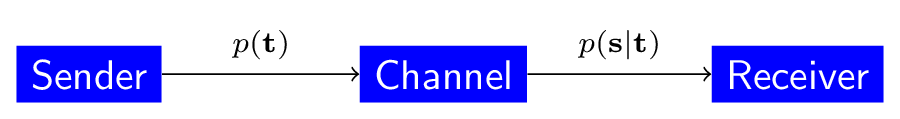

In [15]:
%%tikz
\tikzset{every node/.style={font=\sffamily,white}} 
\node[fill=blue] at (0,0) (a) {Sender}; 
\node[fill=blue] at (3,0) (b) {Channel}; 
\node[fill=blue] at (6,0) (c) {Receiver}; 
\draw[->] (a) -- (b) node [midway,above,font=\scriptsize,black]{$p(\mathbf{t})$}; 
\draw[->] (b) -- (c) node [midway,above,font=\scriptsize,black]{$p(\mathbf{s}|\mathbf{t})$};

* What does $\prob(\source|\target)$ correspond to?
* What does $\prob(\target)$ correspond to?

### Noisy Channel in MT
* $\prob_{\params_s}(\source|\target)$ is called the **translation model**
* $\prob_{\params_t}(\target)$ is the **language model**

MLE for $\prob_\params(\target,\source) = \prob_{\params_t}(\target) \prob_{\params_s}(\source|\target)$ can be calculated in two **independent steps**:
* Estimate $\params_t$ for $\prob_{\params_t}(\target)$
* Estimate $\params_s$ for $\prob_{\params_s}(\source|\target)$

Why useful?

## Impossible Translation Model

$$
\prob^{\text{Impossible}}_\params(\source|\target) = \params_{\source,\target}
$$

Why impossible?

Generally we want models that **factorize** (break up into smaller parts) for dealing with 

* **sparsity**
* **memory limitations**
* **runtime limitations**

How did **language models** do this? 

Look at example for inspiration:

|Token| 1 | 2 | 3 | 4 | 
|-|---|---|---|---|
|**Target**| the | house | is | small |
|**Source**| das | Haus | ist | klein |

$$
\prob_\theta(\source|\target) = \prob_\theta(\text{das | the}) \prob_\theta(\text{Haus | house}) \prob_\theta(\text{ist | is}) \prob_\theta(\text{klein | small})
$$

## Naive Translation Model

$$
\prob_\params^\text{Naive}(\source|\target) = \prod_i^{\length{\source}} \prob_\params(\ssource_i|\starget_i) = \prod_i^{\length{\source}} \param_{\ssource_i,\starget_i}
$$

Why naive?

### Training

Use the **Maximum Likelihood Estimate**:

$$
\params^* = \argmax_\params \sum_{(\target,\source) \in \train} \log \prob_\params(\source|\target)
$$


Amounts to **counting**: 

$$
\param^*_{\ssource,\starget} = \frac{\counts{\train}{s,t}}{\counts{\train}{t}} 
$$


In Python:

In [68]:
from collections import defaultdict 
def learn_naive_model(data):
    norm = defaultdict(float)
    counts = defaultdict(float) 
    for target, source in data:
        for i in range(0, len(target)):
            norm[target[i]] += 1.0
            counts[(source[i],target[i])] += 1.0
    result = {}
    for (source,target),score in counts.items():
        result[(source,target)] = score / norm[target]
    return result
learn_naive_model([[('the','house'),('das','Haus')],[('the','house'),('das','Gebauede')]])

{('Gebauede', 'house'): 0.5, ('Haus', 'house'): 0.5, ('das', 'the'): 1.0}

On all data:

In [82]:
util.Table(train)

"['the', 'house', 'is', 'small']","['das', 'Haus', 'ist', 'klein']"
"['the', 'house', 'is', 'small']","['klein', 'ist', 'das', 'Haus']"
"['a', 'man', 'is', 'tall']","['ein', 'Mann', 'ist', 'groß']"
"['my', 'house', 'is', 'small']","['klein', 'ist', 'mein', 'Haus']"


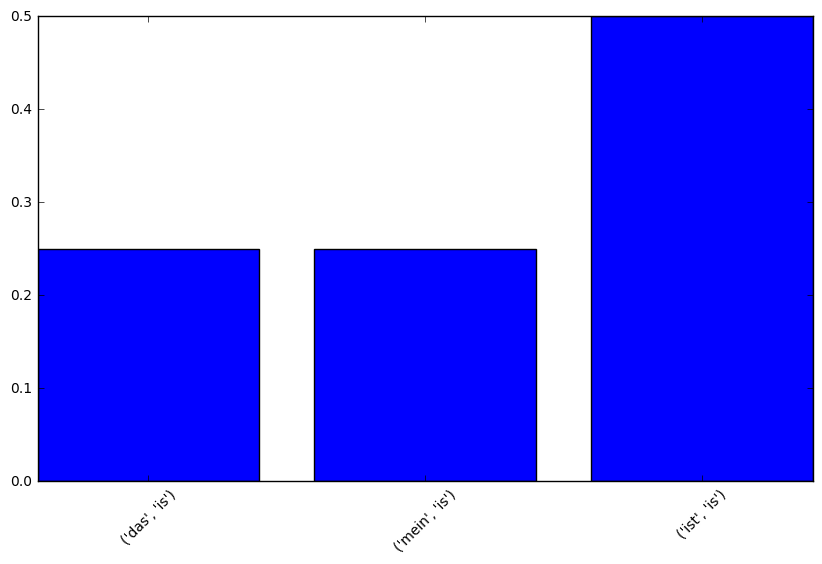

In [77]:
table = learn_naive_model(train)
plot_table_for_target(table, "is")

### Translation / Decoding

Find the highest scoring target $\y$ 

$$
\target^*(\source) = \argmax_\target \prod_i^{\length{\source}} \prob_\params(\ssource_i|\starget_i)
$$


How about **brute-force** (like in our SP example)?

### Local Decoding 

How to find this $\argmax$?
$$
\argmax_{y_1,y_2} f_1(y_1) f_2(y_2) = ?
$$


### Local Decoding for the Naive Model

$$
\target^*(\source) = \argmax_\target \prod_i^{\length{\source}} \prob_\params(\ssource_i|\starget_i) \\
= (\argmax_{\starget_1}  \prob_\params(\ssource_1|\starget_1), \ldots, \argmax_{\starget_{\length{\source}}}  \prob_\params(\ssource_{\length{\source}}|\starget_{\length{\source}}))
$$



In Python

In [80]:
def decode(source_sent, model, lm):
    source_to_targets = defaultdict(list)
    for (source,target),prob in model.items():
        source_to_targets[source] += [(target,prob)]
    result = []
    for tok in source_sent:
        candidates = source_to_targets[tok]
        multiplied_with_lm = [(target,prob * lm.probability(target)) for target, prob in candidates]
        target = max(multiplied_with_lm, key=lambda t: t[1])
        result.append(target[0])
    return result

lm = UniformLM(set([target for _, target in table.keys()]))
decode(["ein", "Mann"], table, lm)

['a', 'man']